# winddy

研究Loss线性加权对某一类标签的保护作用

In [2]:
import torch 
import numpy as np
import os
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from LeNet import LeNet
from torch.autograd import Variable
import sys
sys.path.append('./utils')
from myUtils import my_fgsm, my_imshow
%matplotlib inline

In [3]:
NORMALIZE = True
DEVICE = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [4]:
if NORMALIZE:
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
else:
    trans = transforms.Compose([
        transforms.ToTensor(),
    ])

In [5]:
data_home = '/data/winddy/'

train_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=True, download=True, transform=trans)
test_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=False, download=True, transform=trans)

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=2)

## 对每一类标签分别进行保护

In [6]:
#读取 model_adv模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_adv.pt


In [7]:
# 记录结果
results_infos = {}

# 先读取未经过对抗训练的模型
# 在进行对抗训练
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

epsilon = 0.3
criterion = torch.nn.CrossEntropyLoss()
    
for i_label in range(10):
    
    # 读取预训练模型
    model_linear_adv = LeNet()
    model_linear_adv.load_state_dict(torch.load(model_path))
    print('read model: {}'.format(model_path))
    model_linear_adv = model_linear_adv.to(DEVICE)
    model_linear_adv.train()
    
    optimizer = torch.optim.SGD(params=model_linear_adv.parameters(), lr=0.01, momentum=0.5)
    loss_F = torch.nn.functional.cross_entropy
    
    weights_linear = torch.Tensor([1.0,1.0,1.0,1.0,1.0,
                              1.0,1.0,1.0,1.0,1.0])
    weights_linear[i_label] = 5.0
    weights_linear = weights_linear.to(DEVICE)
    LABEL = 'Protect Label ' + str(i_label)
    print('weights_linear: {}'.format(weights_linear))
    
    # 开始训练
    for epoch in range(10):
        count = 0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_linear_adv, criterion, epsilon, DEVICE)
    
            optimizer.zero_grad()
            output = model_linear_adv(data)
            loss = loss_F(output, target, weight=weights_linear)
            
            loss.backward()
            optimizer.step()
            
            count += len(data)
            print('\r {}|{}'.format(count, len(train_loader.dataset)), end='')
            
        # 测试
        correct = 0
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model_linear_adv(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        print('epoch: {}, test correct: {}'.format(epoch,correct/len(test_loader.dataset)))
        
    ## 训练结束
    
    # 比较结果
    
    ## 对 model_linear_adv的评估
    print('对 model_linear_adv的评估')
    results_info = {}
    model_linear_adv.eval()
    images_targets = {}
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_linear_adv, criterion, epsilon, DEVICE)
            output = model_linear_adv(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct: {}'.format(special_index,correct/count))
    results_info[1] = images_targets
    
    ## 对 model_adv 的评估
    print('对 model_adv 的评估')
    model_adv.eval()
    images_targets = {}
    
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_adv, criterion, epsilon, DEVICE)
            output = model_adv(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct: {}'.format(special_index,correct/count))
    results_info[2] = images_targets
    
    # 记录结果
    results_infos[i_label] = results_info

read model: ./model/LeNet_MNIST_adv.pt
weights_linear: tensor([5., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:7')
 60000|60000epoch: 0, test correct: 0.9868
 60000|60000epoch: 1, test correct: 0.9912
 60000|60000epoch: 2, test correct: 0.9896
 60000|60000epoch: 3, test correct: 0.9908
 60000|60000epoch: 4, test correct: 0.9908
 60000|60000epoch: 5, test correct: 0.9902
 60000|60000epoch: 6, test correct: 0.99
 60000|60000epoch: 7, test correct: 0.9906
 60000|60000epoch: 8, test correct: 0.9906
 60000|60000epoch: 9, test correct: 0.9912
对 model_linear_adv的评估
 980
 0 correct: 0.9897959183673469
 1135
 1 correct: 0.9850220264317181
 1032
 2 correct: 0.9757751937984496
 1010
 3 correct: 0.9435643564356435
 982
 4 correct: 0.9704684317718941
 892
 5 correct: 0.9372197309417041
 958
 6 correct: 0.9686847599164927
 1028
 7 correct: 0.9678988326848249
 974
 8 correct: 0.9414784394250514
 1009
 9 correct: 0.8979187314172448
对 model_adv 的评估
 980
 0 correct: 0.9785714285714285
 1135
 1 cor

 60000|60000epoch: 5, test correct: 0.9902
 60000|60000epoch: 6, test correct: 0.9891
 60000|60000epoch: 7, test correct: 0.9902
 60000|60000epoch: 8, test correct: 0.991
 60000|60000epoch: 9, test correct: 0.9907
对 model_linear_adv的评估
 980
 0 correct: 0.9826530612244898
 1135
 1 correct: 0.9832599118942731
 1032
 2 correct: 0.9748062015503876
 1010
 3 correct: 0.9623762376237623
 982
 4 correct: 0.9511201629327902
 892
 5 correct: 0.9473094170403588
 958
 6 correct: 0.9801670146137788
 1028
 7 correct: 0.9601167315175098
 974
 8 correct: 0.9383983572895277
 1009
 9 correct: 0.9236868186323092
对 model_adv 的评估
 980
 0 correct: 0.9785714285714285
 1135
 1 correct: 0.9638766519823788
 1032
 2 correct: 0.9689922480620154
 1010
 3 correct: 0.9524752475247524
 982
 4 correct: 0.9490835030549898
 892
 5 correct: 0.8923766816143498
 958
 6 correct: 0.965553235908142
 1028
 7 correct: 0.9464980544747081
 974
 8 correct: 0.9558521560574949
 1009
 9 correct: 0.9256689791873142
read model: ./model

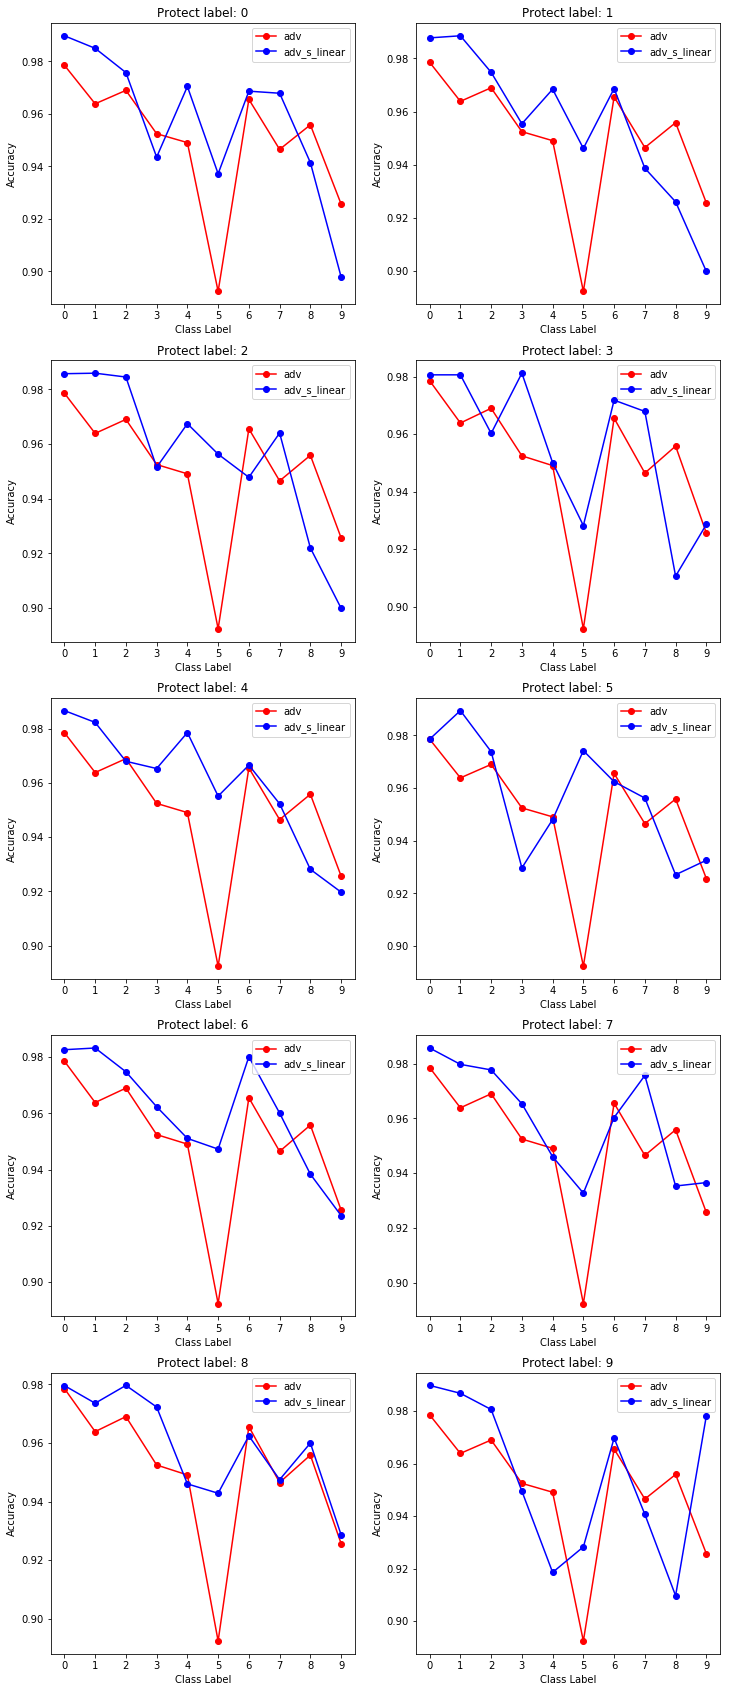

In [8]:
x = [0,1,2,3,4,5,6,7,8,9]
nrows = 5
ncols = 2
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.figure(figsize=(6 * ncols, 6 * nrows))
count = 1

for i in results_infos.keys():
    tmp = results_infos[i]
    
    tmp_s_adv = tmp[1]
    tmp_adv = tmp[2]
    tmp_s_arr = []
    tmp_arr = []
    for key_tmp in tmp_s_adv.keys():
        
        tmp_s_arr.append(tmp_s_adv[key_tmp][1])
        tmp_arr.append(tmp_adv[key_tmp][1])
    
    plt.subplot(nrows, ncols, count)
    plt.plot(x, tmp_arr, 'ro-', label='adv')
    plt.plot(x, tmp_s_arr, 'bo-', label='adv_s_linear')
    plt.xticks(x)
    plt.title('Protect label: '+str(i))
    plt.legend(loc="upper right")
    plt.xlabel('Class Label')
    plt.ylabel('Accuracy')
    count += 1

## 对每一类标签迭代进行保护

In [9]:
#读取 model_adv模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_adv.pt


In [10]:
# 记录结果
results_infos = {}

# 先读取未经过对抗训练的模型
# 在进行对抗训练
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

# 读取预训练模型
model_linear_adv = LeNet()
model_linear_adv.load_state_dict(torch.load(model_path))
model_linear_adv = model_linear_adv.to(DEVICE)
model_linear_adv.train()

optimizer = torch.optim.SGD(params=model_linear_adv.parameters(), lr=0.01, momentum=0.5)
loss_F = torch.nn.functional.cross_entropy
    
epsilon = 0.3
criterion = torch.nn.CrossEntropyLoss()
    
for i_label in range(10):    
    weights_linear = torch.Tensor([1.0,1.0,1.0,1.0,1.0,
                              1.0,1.0,1.0,1.0,1.0])
    weights_linear[i_label] = 5.0
    weights_linear = weights_linear.to(DEVICE)
    LABEL = 'Protect Label ' + str(i_label)
    print('weights_linear: {}'.format(weights_linear))
    
    # 开始训练
    for epoch in range(10):
        count = 0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_linear_adv, criterion, epsilon, DEVICE)
    
            optimizer.zero_grad()
            output = model_linear_adv(data)
            loss = loss_F(output, target, weight=weights_linear)
            
            loss.backward()
            optimizer.step()
            
            count += len(data)
            print('\r {}|{}'.format(count, len(train_loader.dataset)), end='')
            
        # 测试
        correct = 0
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model_linear_adv(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        print('epoch: {}, test correct: {}'.format(epoch,correct/len(test_loader.dataset)))
        
    ## 训练结束
    
    # 比较结果
    
    ## 对 model_linear_adv的评估
    print('对 model_linear_adv的评估')
    results_info = {}
    model_linear_adv.eval()
    images_targets = {}
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_linear_adv, criterion, epsilon, DEVICE)
            output = model_linear_adv(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct: {}'.format(special_index,correct/count))
    results_info[1] = images_targets
    
    ## 对 model_adv 的评估
    print('对 model_adv 的评估')
    model_adv.eval()
    images_targets = {}
    
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_adv, criterion, epsilon, DEVICE)
            output = model_adv(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct: {}'.format(special_index,correct/count))
    results_info[2] = images_targets
    
    # 记录结果
    results_infos[i_label] = results_info

weights_linear: tensor([5., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:7')
 60000|60000epoch: 0, test correct: 0.9893
 60000|60000epoch: 1, test correct: 0.9902
 60000|60000epoch: 2, test correct: 0.9902
 60000|60000epoch: 3, test correct: 0.9901
 60000|60000epoch: 4, test correct: 0.9897
 60000|60000epoch: 5, test correct: 0.9896
 60000|60000epoch: 6, test correct: 0.9908
 60000|60000epoch: 7, test correct: 0.991
 60000|60000epoch: 8, test correct: 0.9901
 60000|60000epoch: 9, test correct: 0.9909
对 model_linear_adv的评估
 980
 0 correct: 0.9928571428571429
 1135
 1 correct: 0.9726872246696036
 1032
 2 correct: 0.9728682170542635
 1010
 3 correct: 0.9603960396039604
 982
 4 correct: 0.945010183299389
 892
 5 correct: 0.9540358744394619
 958
 6 correct: 0.9613778705636743
 1028
 7 correct: 0.9678988326848249
 974
 8 correct: 0.9301848049281314
 1009
 9 correct: 0.9306243805748265
对 model_adv 的评估
 980
 0 correct: 0.9785714285714285
 1135
 1 correct: 0.9638766519823788
 1032
 2 corre

 980
 0 correct: 0.9857142857142858
 1135
 1 correct: 0.9806167400881057
 1032
 2 correct: 0.9718992248062015
 1010
 3 correct: 0.9643564356435643
 982
 4 correct: 0.9623217922606925
 892
 5 correct: 0.9473094170403588
 958
 6 correct: 0.9780793319415448
 1028
 7 correct: 0.9717898832684825
 974
 8 correct: 0.9486652977412731
 1009
 9 correct: 0.910802775024777
对 model_adv 的评估
 980
 0 correct: 0.9785714285714285
 1135
 1 correct: 0.9638766519823788
 1032
 2 correct: 0.9689922480620154
 1010
 3 correct: 0.9524752475247524
 982
 4 correct: 0.9490835030549898
 892
 5 correct: 0.8923766816143498
 958
 6 correct: 0.965553235908142
 1028
 7 correct: 0.9464980544747081
 974
 8 correct: 0.9558521560574949
 1009
 9 correct: 0.9256689791873142
weights_linear: tensor([1., 1., 1., 1., 1., 1., 1., 5., 1., 1.], device='cuda:7')
 60000|60000epoch: 0, test correct: 0.9905
 60000|60000epoch: 1, test correct: 0.9907
 60000|60000epoch: 2, test correct: 0.9909
 60000|60000epoch: 3, test correct: 0.9912
 6

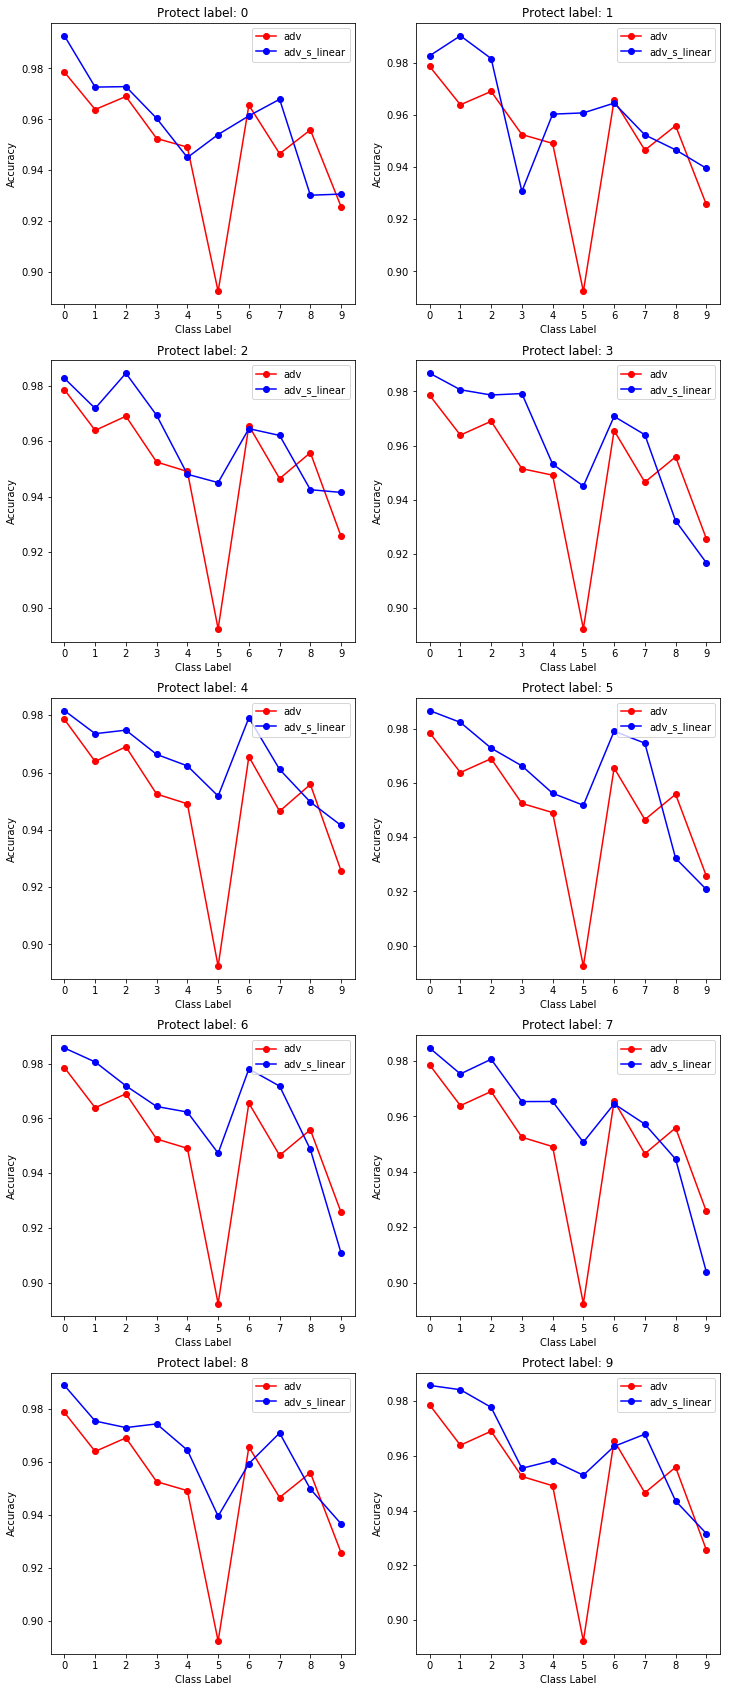

In [11]:
x = [0,1,2,3,4,5,6,7,8,9]
nrows = 5
ncols = 2
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.figure(figsize=(6 * ncols, 6 * nrows))
count = 1

for i in results_infos.keys():
    tmp = results_infos[i]
    
    tmp_s_adv = tmp[1]
    tmp_adv = tmp[2]
    tmp_s_arr = []
    tmp_arr = []
    for key_tmp in tmp_s_adv.keys():
        
        tmp_s_arr.append(tmp_s_adv[key_tmp][1])
        tmp_arr.append(tmp_adv[key_tmp][1])
    
    plt.subplot(nrows, ncols, count)
    plt.plot(x, tmp_arr, 'ro-', label='adv')
    plt.plot(x, tmp_s_arr, 'bo-', label='adv_s_linear')
    plt.xticks(x)
    plt.title('Protect label: '+str(i))
    plt.legend(loc="upper right")
    plt.xlabel('Class Label')
    plt.ylabel('Accuracy')
    count += 1

# 拓展

同时保护多个类

In [7]:
#读取 model_adv模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_adv.pt


In [8]:
# 记录结果
results_infos = {}

# 先读取未经过对抗训练的模型
# 在进行对抗训练
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

epsilon = 0.3
criterion = torch.nn.CrossEntropyLoss()
    
for i_label in range(10):
    
    # 读取预训练模型
    model_linear_adv = LeNet()
    model_linear_adv.load_state_dict(torch.load(model_path))
    print('read model: {}'.format(model_path))
    model_linear_adv = model_linear_adv.to(DEVICE)
    model_linear_adv.train()
    
    optimizer = torch.optim.SGD(params=model_linear_adv.parameters(), lr=0.01, momentum=0.5)
    loss_F = torch.nn.functional.cross_entropy
    
    weights_linear = torch.Tensor([1.0,1.0,1.0,1.0,1.0,
                              1.0,1.0,1.0,1.0,1.0])
    weights_linear[i_label] = 5.0
    weights_linear[(i_label+1) % 10] = 5.0
    weights_linear = weights_linear.to(DEVICE)
    LABEL = 'Protect Label ' + str(i_label)
    print('weights_linear: {}'.format(weights_linear))
    
    # 开始训练
    for epoch in range(10):
        count = 0
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_linear_adv, criterion, epsilon, DEVICE)
    
            optimizer.zero_grad()
            output = model_linear_adv(data)
            loss = loss_F(output, target, weight=weights_linear)
            
            loss.backward()
            optimizer.step()
            
            count += len(data)
            print('\r {}|{}'.format(count, len(train_loader.dataset)), end='')
            
        # 测试
        correct = 0
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model_linear_adv(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        print('epoch: {}, test correct: {}'.format(epoch,correct/len(test_loader.dataset)))
        
    ## 训练结束
    
    # 比较结果
    
    ## 对 model_linear_adv的评估
    print('对 model_linear_adv的评估')
    results_info = {}
    model_linear_adv.eval()
    images_targets = {}
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_linear_adv, criterion, epsilon, DEVICE)
            output = model_linear_adv(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct: {}'.format(special_index,correct/count))
    results_info[1] = images_targets
    
    ## 对 model_adv 的评估
    print('对 model_adv 的评估')
    model_adv.eval()
    images_targets = {}
    
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            data, sign = my_fgsm(data, target, model_adv, criterion, epsilon, DEVICE)
            output = model_adv(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct: {}'.format(special_index,correct/count))
    results_info[2] = images_targets
    
    # 记录结果
    results_infos[i_label] = results_info

read model: ./model/LeNet_MNIST_adv.pt
weights_linear: tensor([5., 5., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:7')
 60000|60000epoch: 0, test correct: 0.9904
 60000|60000epoch: 1, test correct: 0.9876
 60000|60000epoch: 2, test correct: 0.9896
 60000|60000epoch: 3, test correct: 0.9904
 60000|60000epoch: 4, test correct: 0.991
 60000|60000epoch: 5, test correct: 0.9877
 60000|60000epoch: 6, test correct: 0.9895
 60000|60000epoch: 7, test correct: 0.9895
 60000|60000epoch: 8, test correct: 0.9908
 60000|60000epoch: 9, test correct: 0.9899
对 model_linear_adv的评估
 980
 0 correct: 0.9918367346938776
 1135
 1 correct: 0.9947136563876652
 1032
 2 correct: 0.9515503875968992
 1010
 3 correct: 0.9663366336633663
 982
 4 correct: 0.9480651731160896
 892
 5 correct: 0.9495515695067265
 958
 6 correct: 0.964509394572025
 1028
 7 correct: 0.9212062256809338
 974
 8 correct: 0.9353182751540041
 1009
 9 correct: 0.9375619425173439
对 model_adv 的评估
 980
 0 correct: 0.9785714285714285
 1135
 1 cor

 60000|60000epoch: 4, test correct: 0.9893
 60000|60000epoch: 5, test correct: 0.99
 60000|60000epoch: 6, test correct: 0.9905
 60000|60000epoch: 7, test correct: 0.9902
 60000|60000epoch: 8, test correct: 0.9902
 60000|60000epoch: 9, test correct: 0.9888
对 model_linear_adv的评估
 980
 0 correct: 0.9806122448979592
 1135
 1 correct: 0.9797356828193833
 1032
 2 correct: 0.9505813953488372
 1010
 3 correct: 0.9683168316831683
 982
 4 correct: 0.9582484725050916
 892
 5 correct: 0.9383408071748879
 958
 6 correct: 0.9791231732776617
 1028
 7 correct: 0.9863813229571985
 974
 8 correct: 0.8583162217659137
 1009
 9 correct: 0.8889990089197225
对 model_adv 的评估
 980
 0 correct: 0.9785714285714285
 1135
 1 correct: 0.9638766519823788
 1032
 2 correct: 0.9689922480620154
 1010
 3 correct: 0.9524752475247524
 982
 4 correct: 0.9490835030549898
 892
 5 correct: 0.8923766816143498
 958
 6 correct: 0.965553235908142
 1028
 7 correct: 0.9464980544747081
 974
 8 correct: 0.9558521560574949
 1009
 9 corre

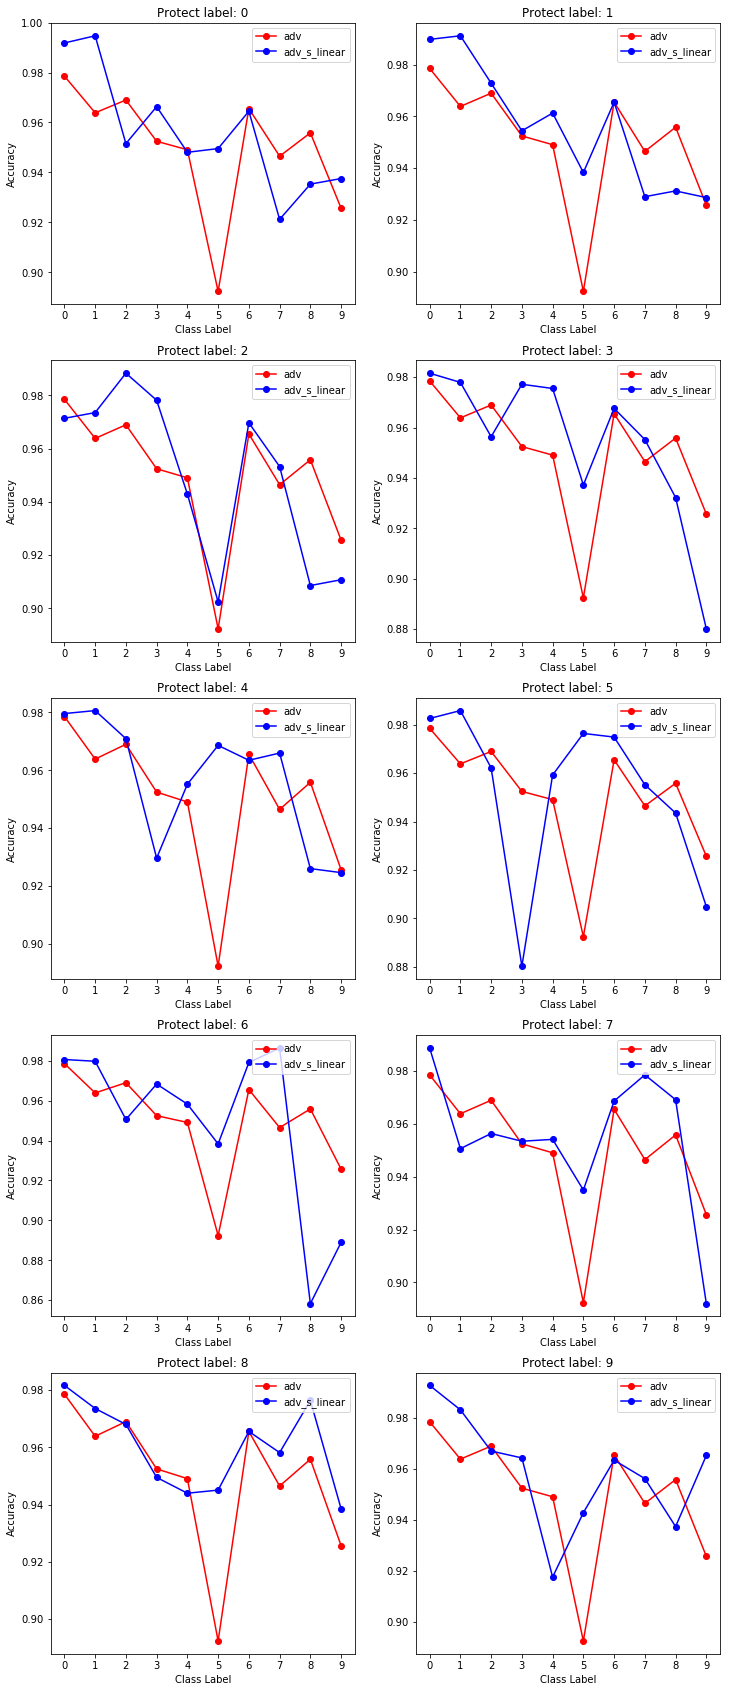

In [9]:
x = [0,1,2,3,4,5,6,7,8,9]
nrows = 5
ncols = 2
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.figure(figsize=(6 * ncols, 6 * nrows))
count = 1

for i in results_infos.keys():
    tmp = results_infos[i]
    
    tmp_s_adv = tmp[1]
    tmp_adv = tmp[2]
    tmp_s_arr = []
    tmp_arr = []
    for key_tmp in tmp_s_adv.keys():
        
        tmp_s_arr.append(tmp_s_adv[key_tmp][1])
        tmp_arr.append(tmp_adv[key_tmp][1])
    
    plt.subplot(nrows, ncols, count)
    plt.plot(x, tmp_arr, 'ro-', label='adv')
    plt.plot(x, tmp_s_arr, 'bo-', label='adv_s_linear')
    plt.xticks(x)
    plt.title('Protect label: '+str(i))
    plt.legend(loc="upper right")
    plt.xlabel('Class Label')
    plt.ylabel('Accuracy')
    count += 1